In [14]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

In [15]:
torch.manual_seed(123)

In [16]:
transform = transforms.ToTensor()

# The "transforms.ToTensor()" code, will download the MNist images and convert them into tensors, in order to be used on our deep learning project. 

# Point of attention: when we import the mnist images like that, the "transforms" method will divide all pixels values by 255(In RGB scale, the pixels are presented with 3 layers of matrix representing the three fundamental colors. In this case, the images are given on grey scale). The idea of didviding each pixel, is to bring the values of the grey scale into a values between 0 and 1, in order to make the neural network process it faster as the values are been normalized.

In [17]:
train = datasets.MNIST(root = '.', train = True, download = True, transform = transform)
test = datasets.MNIST(root = '.', train = False, download = True, transform = transform)

In [18]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

The data here, is presented between 0(Dark colors) to 255(Light colors). The values are not yet divided by 255, they are still on it's original values. The division is made when the loader is called


In [19]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

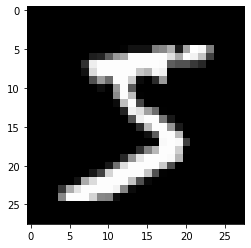

In [20]:
image = next(iter(train_loader))[0][0].view(28,28) 
# The view here is made in order to transform the original torch data model that is (1, 1, 28, 28) "Number of batches or Images", "Number of channels and filters (RGB)", number of pixels from the image;
plt.imshow(image, cmap = 'gray')

In [21]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features = 32*5*5, out_features = 128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X

In [23]:
 net = classifier()
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.Adam(net.parameters())

## Creating the training step of the model

In [24]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [25]:
net.to(device)

classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Creating a loop for training our Convolutional neural network:

In [30]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy

        print('\rEpoch {:3d} - Loop {:3d} de {:3d}: perda {:3.2f} - precisão {:3.2f}'.format(epoch + 1,
        i+1,
        len(loader),
        loss,
        accuracy), end = '\r')

    print('ÉPOCA {:3d} finalizada: Perda {:.5f} - precisão {:.5f}'.format(epoch + 1,
    running_loss/len(loader),
    running_accuracy/len(loader)))

In [31]:
for epoch in range(5):
    print('Training.....')
    training_loop(train_loader, epoch)
    net.eval()
    print('Validating.....')
    training_loop(test_loader, epoch)
    net.train()

Training.....
ÉPOCA   1 finalizada: Perda 0.16272 - precisão 0.95176
Validating.....
ÉPOCA   1 finalizada: Perda 0.13375 - precisão 0.95847
Training.....
ÉPOCA   2 finalizada: Perda 0.05158 - precisão 0.98485
Validating.....
ÉPOCA   2 finalizada: Perda 0.05793 - precisão 0.98398
Training.....
ÉPOCA   3 finalizada: Perda 0.03756 - precisão 0.98865
Validating.....
ÉPOCA   3 finalizada: Perda 0.04119 - precisão 0.98784
Training.....
ÉPOCA   4 finalizada: Perda 0.02948 - precisão 0.99067
Validating.....
ÉPOCA   4 finalizada: Perda 0.02796 - precisão 0.99288
Training.....
ÉPOCA   5 finalizada: Perda 0.02651 - precisão 0.99192
Validating.....
ÉPOCA   5 finalizada: Perda 0.02640 - precisão 0.99268


### Evaluating the results from our training:

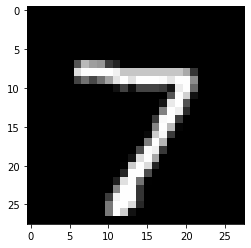

In [32]:
# Loading an image to our model:
image = next(iter(test_loader))[0][0].view(28, 28)
plt.imshow(image, cmap='gray')

In [33]:
image.shape

torch.Size([28, 28])

In [34]:
# The shape that the image has now, is the correct one to be shown, as we did on the above cell. But, in order to enter as an input value to our convolutional neural network, we must have the torch pattern of shape (batch_size; number of channels; hight; width)

image = image.view([1, 1, 28, 28])
image.shape

torch.Size([1, 1, 28, 28])

In [35]:
net.eval()
image = image.to(device)

In [54]:
prediction = net.forward(image)
prediction

tensor([[ -4.8419,  -2.6710,  -2.9500,  -0.4587,  -3.2091,  -5.9689, -11.5708,
          11.6728,  -3.9619,   0.4179]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [55]:
prediction = F.softmax(prediction) # This is done in order to transform all retrived data in values of probabilities 
prediction

tensor([[6.7257e-08, 5.8960e-07, 4.4606e-07, 5.3868e-06, 3.4424e-07, 2.1790e-08,
         8.0433e-11, 9.9998e-01, 1.6215e-07, 1.2943e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [56]:
prediction = prediction.cpu().detach().numpy()
prediction

array([[6.7257382e-08, 5.8959887e-07, 4.4606301e-07, 5.3867675e-06,
        3.4423744e-07, 2.1790466e-08, 8.0432890e-11, 9.9997997e-01,
        1.6214726e-07, 1.2943262e-05]], dtype=float32)

In [57]:
result = np.argmax(prediction)
result

7

In [58]:
print('The result of prediction for the given image was: ', result, '\nWith an accuracy of ', (prediction[[0],[np.argmax(prediction)]]*100)[0], '%')

The result of prediction for the given image was:  7 
With an accuracy of  99.998 %
